In [1]:
import atexit
import copy
import gym
import json
from kaggle_environments import make
import math
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
from scipy.stats import rankdata
from subprocess import Popen, PIPE
import sys
import tqdm
from typing import *

#from lux_ai.lux.game import Game
#from lux_ai.lux_gym.lux_env import LuxEnv
#from lux_ai.rl_agent.rl_agent import RLAgent

env = make("lux_ai_2021")
SEED_COUNTER = 0

Loading environment football failed: No module named 'gfootball'


In [8]:
import torch


test = torch.arange(4).reshape(2,2)

d = 1
torch.stack([test, test, test], dim=d).sum(dim=d)

tensor([[0, 3],
        [6, 9]])

In [2]:
env = make("lux_ai_2021", configuration={"seed": 820635226 + SEED_COUNTER}, debug=True)
SEED_COUNTER += 1
env.reset()
env.run(["main.py", "main.py"])
env.render(mode='ipython', width=1200, height=1000)

In [8]:
from lux_ai.handcrafted_agents.needs_name_v0 import Agent

agent = Agent(env.steps[0][0]["observation"], env.configuration)
turn = 214
agent.set_to_turn(env.steps[turn][0]["observation"], env.configuration, turn)
agent(env.steps[turn + 1][0]["observation"], env.configuration);

['m u_5 n', "dst 'Turn: 215'", "dt 9 6 'MineFuelLocal_0/5:_0' 16"]

In [9]:
agent.worker_actions

{Unit: team_0/type_0/pos_(9, 6): [Action(actor=Unit: team_0/type_0/pos_(9, 6), action_str='m u_5 n', debug_strs="dt 9 6 'MineFuelLocal_0/5:_0' 16"),
  Action(actor=Unit: team_0/type_0/pos_(9, 6), action_str='m u_5 e', debug_strs="dt 9 6 'MineFuelLocal_1/5:_0' 16"),
  Action(actor=Unit: team_0/type_0/pos_(9, 6), action_str='m u_5 s', debug_strs="dt 9 6 'MineFuelLocal_2/5:_0' 16"),
  Action(actor=Unit: team_0/type_0/pos_(9, 6), action_str='m u_5 w', debug_strs="dt 9 6 'MineFuelLocal_3/5:_0' 16"),
  Action(actor=Unit: team_0/type_0/pos_(9, 6), action_str='m u_5 c', debug_strs="dt 9 6 'MineFuelLocal_4/5:_0' 16")]}

In [6]:

for i, mat in enumerate(agent.smoothed_fps_mats):
    #plt.imshow(mat + agent.my_mobile_units_mat * mat.max() + agent.my_cities_mat * mat.max())
    plt.imshow(mat)
    plt.colorbar()
    plt.show();

AttributeError: 'Agent' object has no attribute 'smoothed_frps_mats'

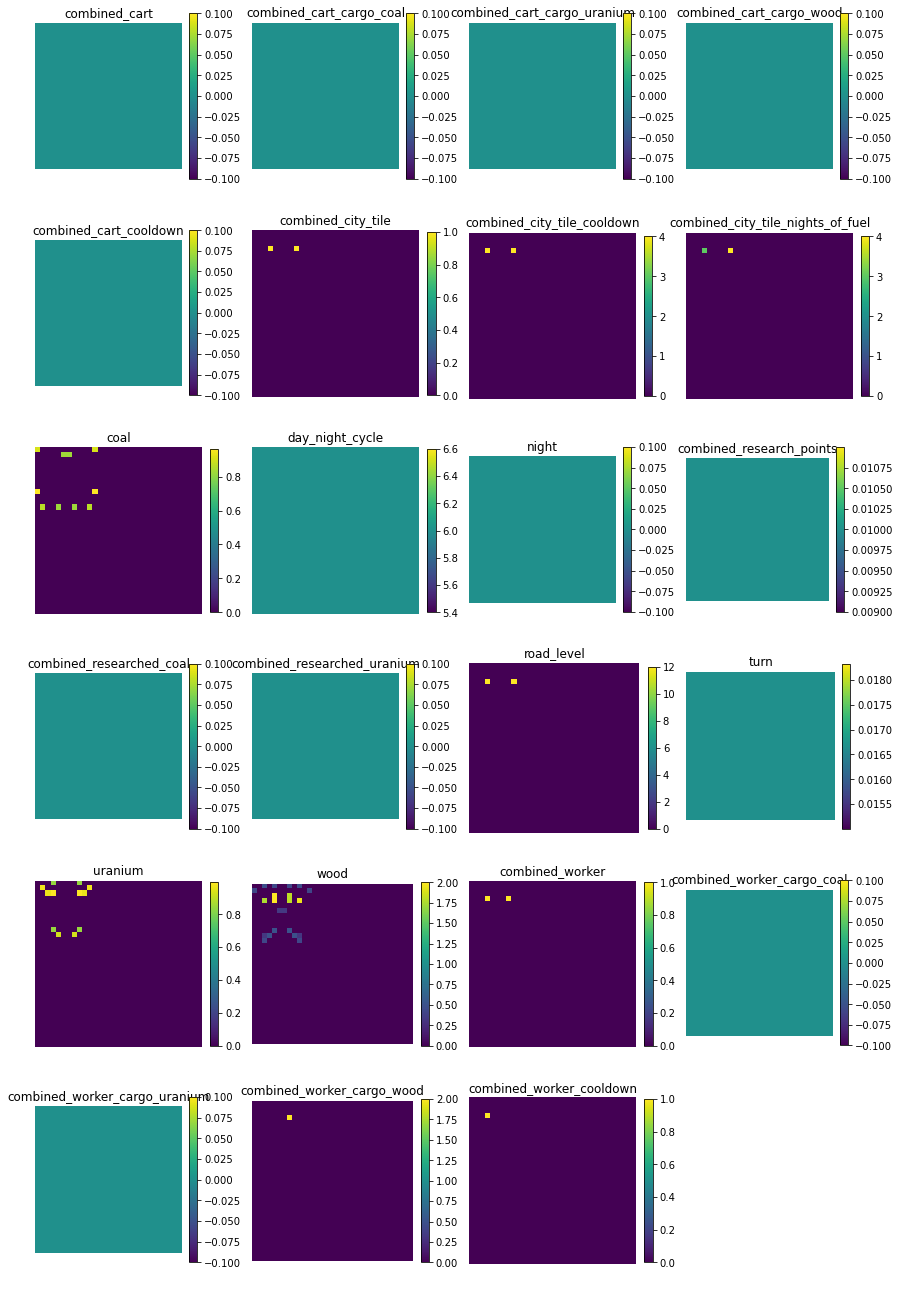

In [5]:
rl_agent = RLAgent(env.steps[0][0]["observation"], env.configuration)
turn = 6
rl_agent.set_to_turn(env.steps[turn][0]["observation"], env.configuration, turn)
obs = rl_agent.get_env_output()["obs"]

n = len(obs)
width = 4
height = math.ceil(n / width)
fig = plt.figure(constrained_layout=True, figsize=(3 * width, 3 * height))
subfigs = fig.subfigures(height, width).ravel()
cmap = "viridis"

for subfig_idx, (name, tensor) in enumerate(obs.items()):
    tensor = tensor.cpu()
    while len(tensor.shape) < 5:
        tensor = tensor.unsqueeze(-1)
    assert tensor.shape[0] == 1
    assert tensor.shape[1] == 1
    tensor = tensor[0, 0]
    tensor = tensor.expand(-1, 32, 32).clone()
    if tensor.shape[0] == 1:
        tensor = tensor[0]
    elif tensor.shape[0] == 2:
        #tensor[1] *= -1
        tensor = tensor.sum(dim=0)
        name = f"combined_{name}"
    else:
        raise ValueError(f"More than 2 players: {tensor.shape}")
    axes = subfigs[subfig_idx].subplots(1, 1)
    ax = axes
    #mappable = ax.imshow(tensor.numpy().T, cmap=cmap, norm=colors.LogNorm(vmin=1e-8, vmax=tensor.max().item() + 1.))
    mappable = ax.imshow(tensor.numpy().T, cmap=cmap)
    ax.set_title(name)
    ax.axis("off")
    subfigs[subfig_idx].colorbar(mappable, shrink=0.8)
    """
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax = axes[i, j]
       """     

In [2]:
class Observation(Dict[str, any]):
    def __init__(self, player=0):
        self.player = player


def generate_replay(seed: int, all_actions: list[list[str]]) -> dict:
    replay = {}
    replay["seed"] = seed
    replay["allCommands"] = []
    # Always random, right?
    replay["mapType"] = "random"
    replay["teamDetails"] = [{"name": "", "tournamentID": ""} for _ in range(2)]
    # TODO: This will not remain correct
    replay["version"] = "2.1.0"
    replay["results"] = {
        # TODO: These ranks are bogus
        "ranks": [{"rank": i+1, "agentID": i} for i in range(2)],
        "replayFile": ""
    }
    for both_actions in all_actions:
        commands = []
        for i, player_actions in enumerate(both_actions):
            commands.extend([
                {"command": act, "agentID": i}
                for act in player_actions
            ])
        replay["allCommands"].append(commands)
    return replay


def run_game(agent_constructors, seed = None) -> dict:
    env.reset()
    # Initialize environment
    if seed is None:
        env.configuration["seed"] += 1
    else:
        env.configuration["seed"] = seed
    initiate = {
        "type": "start",
        "agent_names": [], # unsure if this is provided?
        "config": env.configuration
    }
    dimension_process.stdin.write((json.dumps(initiate) + "\n").encode())
    dimension_process.stdin.flush()

    agent1res = json.loads(dimension_process.stdout.readline())
    agent2res = json.loads(dimension_process.stdout.readline())
    
    # Initialize agents
    obses = [Observation(0), Observation(1)]
    obses[0]["updates"] = agent1res
    obses[1]["updates"] = agent2res
    agents = [ac(obs, None) for ac, obs in zip(agent_constructors, obses)]
    
    # Edit env object
    env.steps[0][0]["observation"]["updates"] = agent1res
    env.steps[0][1]["observation"]["updates"] = agent2res
    
    all_actions = []
    with tqdm.tqdm() as pbar:
        match_status = {
            "status": None
        }
        while match_status["status"] != "finished":
            actions = [a(obs, None) for a, obs in zip(agents, obses)]
            all_actions.append(actions)
            dimension_process.stdin.write((json.dumps([{"action": act} for act in actions]) + "\n").encode())
            dimension_process.stdin.flush()

            agent1res = json.loads(dimension_process.stdout.readline())
            agent2res = json.loads(dimension_process.stdout.readline())
            match_status = json.loads(dimension_process.stdout.readline())
            obses = [Observation(0), Observation(1)]
            obses[0]["updates"] = agent1res
            obses[1]["updates"] = agent2res
            
            # Edit env object
            env.steps.append(copy.deepcopy(env.steps[0]))
            env.steps[-1][0]["observation"]["updates"] = agent1res
            env.steps[-1][1]["observation"]["updates"] = agent2res
            env.steps[-1][0]["action"] = actions[0]
            env.steps[-1][1]["action"] = actions[1]
            pbar.update()
        # Edit env object
        env.steps[-1][0]["status"] = "DONE"
        env.steps[-1][1]["status"] = "DONE"
    
    return generate_replay(env.configuration["seed"], all_actions)

In [5]:
from lux_ai.rl_agent import rl_agent

custom_replay = run_game([rl_agent.RLAgent, rl_agent.RLAgent])
with open("/home/isaiah/lux_ai/replays/notebook_replay.json", "w") as f:
    f.write(json.dumps(custom_replay))
#custom_replay

36it [00:01, 23.66it/s]


In [3]:
env.render(mode='ipython', width=1200, height=1000)

In [2]:
import json
from kaggle_environments import make
import tqdm

from lux_ai.rl_agent import rl_agent

env = make("lux_ai_2021", debug=True)
obses = env.reset()
while obses[0]["observation"]["updates"][1] != "32 32":
    env = make("lux_ai_2021", debug=True)
    obses = env.reset()

all_actions = []
agents = [rl_agent.RLAgent(o["observation"], None) for o in obses]
with tqdm.tqdm() as pbar:
    while not env.done:
        actions = [a(o["observation"], None) for a, o in zip(agents, obses)]
        all_actions.append(actions)
        
        obses = env.step(actions)
        pbar.update()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/isaiah/miniconda3/envs/lux_ai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-8afeb5fbe002>", line 14, in <module>
    agents = [rl_agent.RLAgent(o["observation"], None) for o in obses]
  File "<ipython-input-3-8afeb5fbe002>", line 14, in <listcomp>
    agents = [rl_agent.RLAgent(o["observation"], None) for o in obses]
  File "/Windows/Users/isaia/Documents/GitHub/Kaggle/Lux_AI_2021/lux_ai/rl_agent/rl_agent.py", line 58, in __init__
    self.env.reset(observation_updates=obs["updates"], force=True)
  File "/Windows/Users/isaia/Documents/GitHub/Kaggle/Lux_AI_2021/lux_ai/lux_gym/wrappers.py", line 225, in reset
    return DictEnv._dict_env_out(super(DictEnv, self).reset(**kwargs))
  File "/home/isaiah/miniconda3/envs/lux_ai/lib/python3.9/site-packages/gym/core.py", line 237, in reset
    return self.env.reset(**kwargs)
  Fil

TypeError: object of type 'NoneType' has no len()

In [5]:
agents[0].game_state.players[0].cities["c_1"].citytiles[0].pos

Position: (4, 6)

In [12]:
env.steps
#env.render(mode='ipython', width=1200, height=1000)
#
#json.loads(env.render(mode='json'))["steps"]

[[{'action': [],
   'reward': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60,
    'step': 0,
    'reward': 0,
    'player': 0,
    'updates': ['0',
     '12 12',
     'rp 0 0',
     'rp 1 0',
     'r wood 0 1 192',
     'r wood 0 4 160',
     'r wood 0 5 128',
     'r wood 0 6 128',
     'r wood 0 7 160',
     'r wood 0 10 192',
     'r uranium 1 0 540',
     'r wood 1 1 800',
     'r wood 1 2 800',
     'r coal 1 5 586',
     'r coal 1 6 586',
     'r wood 1 9 800',
     'r wood 1 10 800',
     'r uranium 1 11 540',
     'r wood 2 1 800',
     'r coal 2 5 540',
     'r coal 2 6 540',
     'r wood 2 10 800',
     'r coal 3 5 628',
     'r coal 3 6 628',
     'r wood 4 5 199',
     'r wood 4 6 199',
     'r wood 5 0 198',
     'r wood 5 11 198',
     'r wood 6 1 168',
     'r coal 6 5 608',
     'r coal 6 6 608',
     'r wood 6 10 168',
     'r wood 9 0 176',
     'r wood 9 11 176',
     'r wood 10 5 122',
     'r wood 10 6 122',
     'r coal 11 1 505',
     'r uranium 

In [13]:
#env.render(mode='html')
#env.render(mode='ipython', height=700, width=800)
with open("/home/isaiah/lux_ai/replays/TEMP.json", 'w') as f:
    f.write(env.render(mode="json"))

In [16]:
json.loads(env.render(mode="json"))

{'configuration': {'actTimeout': 1,
  'episodeSteps': 361,
  'mapType': 'random',
  'runTimeout': 1200,
  'seed': 366889077},
 'description': 'A Novel AI Programming Challenge about Lux',
 'id': '7cca92da-f61d-11eb-a3b1-a85e45512f7a',
 'info': {},
 'name': 'lux_ai_2021',
 'rewards': [0, 0],
 'schema_version': 1,
 'specification': {'action': {'default': 0,
   'description': 'Actions',
   'type': 'array'},
  'agents': [2],
  'configuration': {'actTimeout': {'default': 1,
    'description': 'Maximum runtime (seconds) to obtain an action from an agent.',
    'minimum': 0,
    'type': 'number'},
   'episodeSteps': {'default': 361,
    'description': 'Maximum number of steps the environment can run. Total is this number -1. One complete game is 360 steps',
    'minimum': 2,
    'type': 'integer'},
   'mapType': {'default': 'random',
    'description': 'Map type to use',
    'type': 'string'},
   'parameters': {'description': 'Parameters for Lux AI 2021',
    'type': 'object'},
   'runTimeout

In [14]:
gym.spaces.MultiBinary([10], dtype=np.int64).dtype

TypeError: __init__() got an unexpected keyword argument 'dtype'

In [29]:
env.game_state.map.height, env.game_state.map.width, env.info.keys()

(32, 12, dict_keys(['actions_taken', 'available_actions_mask']))

In [31]:
env.game_state.players[0].units[0].pos

Position: (2, 14)

In [27]:
for i in range(1, 361):
    if (i - 1) % 40 >= 30:
        time = "NIGHT"
    else:
        time = "DAY"
    print(f"{i}: {time}")

1: DAY
2: DAY
3: DAY
4: DAY
5: DAY
6: DAY
7: DAY
8: DAY
9: DAY
10: DAY
11: DAY
12: DAY
13: DAY
14: DAY
15: DAY
16: DAY
17: DAY
18: DAY
19: DAY
20: DAY
21: DAY
22: DAY
23: DAY
24: DAY
25: DAY
26: DAY
27: DAY
28: DAY
29: DAY
30: DAY
31: NIGHT
32: NIGHT
33: NIGHT
34: NIGHT
35: NIGHT
36: NIGHT
37: NIGHT
38: NIGHT
39: NIGHT
40: NIGHT
41: DAY
42: DAY
43: DAY
44: DAY
45: DAY
46: DAY
47: DAY
48: DAY
49: DAY
50: DAY
51: DAY
52: DAY
53: DAY
54: DAY
55: DAY
56: DAY
57: DAY
58: DAY
59: DAY
60: DAY
61: DAY
62: DAY
63: DAY
64: DAY
65: DAY
66: DAY
67: DAY
68: DAY
69: DAY
70: DAY
71: NIGHT
72: NIGHT
73: NIGHT
74: NIGHT
75: NIGHT
76: NIGHT
77: NIGHT
78: NIGHT
79: NIGHT
80: NIGHT
81: DAY
82: DAY
83: DAY
84: DAY
85: DAY
86: DAY
87: DAY
88: DAY
89: DAY
90: DAY
91: DAY
92: DAY
93: DAY
94: DAY
95: DAY
96: DAY
97: DAY
98: DAY
99: DAY
100: DAY
101: DAY
102: DAY
103: DAY
104: DAY
105: DAY
106: DAY
107: DAY
108: DAY
109: DAY
110: DAY
111: NIGHT
112: NIGHT
113: NIGHT
114: NIGHT
115: NIGHT
116: NIGHT
117: NIGHT
1

In [11]:
cell = game_state.map.get_cell_by_pos(game_state.players[0].cities['c_1'].citytiles[0].pos)
cell.has_resource():

False

In [132]:
import itertools

for cell in itertools.chain(*game_state.map.map):
    pass

In [135]:
cell.road

0

In [107]:
player = game_state.players[0]
unit = player.units[0]
unit.cargo.coal

0

In [39]:
env.reset()
while not env.done:
    if (env.game_state.turn // 2) % 2 == 0:
        move = 'n'
    else:
        move = 's'
    # print(move)
    if len(env.game_state.players[0].units) > 0:
        actions = [[env.game_state.players[0].units[0].move(move)], []]
    else:
        actions = [[], []]
    returned = env.step(actions)

In [40]:
env.game_state.players[1].cities, env.game_state.players[0].units, returned

({}, [], (<lux_ai.lux.game.Game at 0x7f399f349640>, [0.0, 0.0], True, {}))

In [25]:
state = [{
    'action': [p.units[0].move('n'), list(p.cities.values())[0].citytiles[0].research()],
    #'reward': 0,
    #'info': {},
    #'observation': {},
    #'status': {}
} for p in game_state.players] * 2
print(state)
dimension_process.stdin.write((json.dumps(state) + "\n").encode())
dimension_process.stdin.flush()

[{'action': ['m u_1 n', 'r 5 7']}, {'action': ['m u_2 n', 'r 10 7']}, {'action': ['m u_1 n', 'r 5 7']}, {'action': ['m u_2 n', 'r 10 7']}]


In [24]:
[l for l in json.loads(dimension_process.stdout.readline()) if l.startswith('u') or l.startswith('rp')]

[]

In [28]:
json.loads(dimension_process.stdout.readline())

{'status': 'running', 'turn': 1, 'max': 361}

'm u_1 NORTH'

In [43]:
dimension_process.stdin.write((json.dumps(env.state) + "\n").encode())

2856

In [51]:
dimension_process.stdout.readline()

b'["rp 0 0","rp 1 0","r uranium 0 2 270","r coal 0 4 336","r coal 1 3 426","r coal 1 4 369","r coal 2 11 312","r wood 3 2 867","r wood 3 5 1164","r wood 4 0 869","r wood 4 2 1180","r wood 4 3 1204","r wood 4 5 1077","r wood 4 6 1026","r uranium 5 11 252","r coal 7 0 440","r wood 7 5 850","r wood 7 11 951","r wood 8 5 770","r wood 8 11 1122","r wood 9 0 866","r wood 9 1 1050","r wood 9 5 850","r wood 9 6 1221","r wood 9 7 1030","r wood 10 0 1260","r wood 10 6 1140","r wood 11 0 1261","r coal 11 9 360","r wood 11 10 1073","r wood 12 0 1261","r coal 12 9 360","r wood 12 10 1073","r wood 13 0 1260","r wood 13 6 1140","r wood 14 0 866","r wood 14 1 1050","r wood 14 5 850","r wood 14 6 1221","r wood 14 7 1030","r wood 15 5 770","r wood 15 11 1122","r coal 16 0 440","r wood 16 5 850","r wood 16 11 951","r uranium 18 11 252","r wood 19 0 869","r wood 19 2 1180","r wood 19 3 1204","r wood 19 5 1077","r wood 19 6 1026","r wood 20 2 867","r wood 20 5 1164","r coal 21 11 312","r coal 22 3 426","r 

In [18]:
game_state._update(agent1res)

In [41]:
env.step([['f'], ['f']])

[{'action': ['f'],
  'reward': 1001,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 3,
   'reward': 1001,
   'player': 0,
   'updates': ['rp 0 0',
    'rp 1 0',
    'r uranium 0 2 270',
    'r coal 0 4 336',
    'r coal 1 3 426',
    'r coal 1 4 369',
    'r coal 2 11 312',
    'r wood 3 2 867',
    'r wood 3 5 1164',
    'r wood 4 0 869',
    'r wood 4 2 1180',
    'r wood 4 3 1204',
    'r wood 4 5 1077',
    'r wood 4 6 1026',
    'r uranium 5 11 252',
    'r coal 7 0 440',
    'r wood 7 5 850',
    'r wood 7 11 951',
    'r wood 8 5 790',
    'r wood 8 11 1122',
    'r wood 9 0 866',
    'r wood 9 1 1050',
    'r wood 9 5 850',
    'r wood 9 6 1221',
    'r wood 9 7 1030',
    'r wood 10 0 1260',
    'r wood 10 6 1140',
    'r wood 11 0 1261',
    'r coal 11 9 360',
    'r wood 11 10 1073',
    'r wood 12 0 1261',
    'r coal 12 9 360',
    'r wood 12 10 1073',
    'r wood 13 0 1260',
    'r wood 13 6 1140',
    'r wood 14 0 866',
    'r wood 14 1 1050',
   